In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm, norm
import matplotlib.pyplot as plt

In [8]:
dataset = pd.read_csv("./export.csv")

print(dataset.columns)
task_dic = {
    'MBPP': 'CODE',
    'WMT': 'T',
    'CNN': 'S',
    'PUBMED': 'S',
}

our_tasks = {
    'S': [128, 32],
    'T': [128, 128],
    'C1': [512, 64],
    'C2': [1024, 64],
    'C3': [1024, 256],
    'CODE': [64, 192],
}

def get_percentile_value(mean, std, percentile):
    percentile_value = norm.ppf(percentile, loc=mean, scale=std)
    return percentile_value

# Example usage
mean = 50
variance = 25
percentile = 0.99

value_at_99_percentile = get_percentile_value(mean, variance, 0.99)
print("Value at 99th percentile:", value_at_99_percentile)

Index(['MBPP_input_len', 'MBPP_output_len', 'CNN_input_seq', 'CNN_output_seq',
       'WMT_CS_input_len', 'WMT_CS_output_len', 'PUBMED_input_seq',
       'PUBMED_output_seq'],
      dtype='object')
Value at 99th percentile: 108.15869685102102


In [9]:
data_np = dataset['MBPP_input_len'].dropna(how='any').to_numpy()
np.mean(data_np)

78.43048128342247

In [10]:
results = []
for col_name in dataset.columns:
    dataset_name = col_name.split("_")[0]
    task = task_dic[dataset_name]
    data_np = dataset[col_name].dropna(how='any').to_numpy()

    if 'output' in col_name:
        is_output = 1
    else:
        is_output = 0
        continue

    our_task_mean = our_tasks[task][is_output]
    
    mean = np.mean(data_np)
    std = np.std(data_np)

    mean_ratio = our_task_mean/mean
    our_task_norm_std = std * mean_ratio

    fit_a, fit_b, trancated_mean, trancated_std = truncnorm.fit(data_np)

    tranc_mean_ratio = our_task_mean/mean
    our_task_tranc_std = trancated_std * tranc_mean_ratio

    results.append({
        'task': task,
        'name': col_name,

        

        'norm_mean': round(mean,2),
        'norm_std': round(std,2),
        'trancated_mean': round(trancated_mean,2),
        'trancated_std': round(trancated_std,2),

        'our_task_mean': our_task_mean,
        'our_task_max_2x': our_task_mean*2,
        'our_task_max_3x': our_task_mean*3,

        'our_task_norm_std': round(our_task_norm_std,2),
        'our_task_tranc_std': round(our_task_tranc_std,2),
        
        'our_task_norm_99': round(get_percentile_value(our_task_mean, our_task_norm_std, 0.99),2),
        'our_task_tranc_99': round(get_percentile_value(our_task_mean, our_task_tranc_std, 0.99),2)


    })
result_pd = pd.DataFrame(results)
result_pd.to_csv("result.csv")

In [14]:
dataset_name = 'wmt16'
dataset_pd = pd.read_csv(f"./profiles_{dataset_name}_profiles.csv", index_col=0)

(array([1.0000e+00, 5.0000e+00, 4.2000e+01, 2.5300e+02, 4.4100e+02,
        8.7900e+02, 7.0900e+02, 7.0300e+02, 9.9000e+02, 1.3660e+03,
        1.7440e+03, 3.1320e+03, 4.3200e+03, 4.1720e+03, 3.6050e+03,
        4.3290e+03, 5.9670e+03, 8.6160e+03, 1.3055e+04, 1.8070e+04,
        1.8702e+04, 1.2202e+04, 1.0441e+04, 1.0028e+04, 1.1020e+04,
        1.3046e+04, 1.5891e+04, 1.7610e+04, 1.4655e+04, 1.0870e+04,
        9.9180e+03, 9.4580e+03, 9.1460e+03, 9.3970e+03, 8.1700e+03,
        6.3960e+03, 4.0790e+03, 3.2310e+03, 3.0790e+03, 3.3240e+03,
        3.4810e+03, 3.6130e+03, 3.4970e+03, 2.7830e+03, 2.2420e+03,
        1.7320e+03, 1.6050e+03, 1.7510e+03, 1.6790e+03, 1.7010e+03,
        1.4970e+03, 1.1790e+03, 1.0030e+03, 1.0120e+03, 9.5900e+02,
        9.9300e+02, 7.5900e+02, 6.9900e+02, 5.7700e+02, 5.2800e+02,
        4.5100e+02, 4.2500e+02, 4.6800e+02, 3.8700e+02, 3.8300e+02,
        2.9300e+02, 3.2200e+02, 2.4100e+02, 2.2400e+02, 2.0000e+02,
        1.8700e+02, 1.8300e+02, 1.6500e+02, 1.27

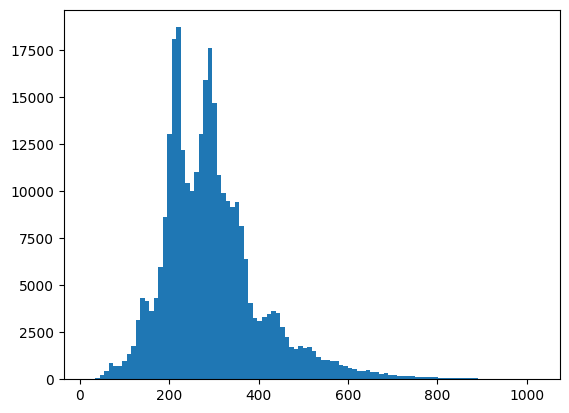

In [7]:
plt.hist(dataset_pd.loc[dataset_pd['output_len']< 1024, 'output_len'], bins=100)

17.55276803048983 306.62072109293183 35.9706222268895 3.5908511787784225


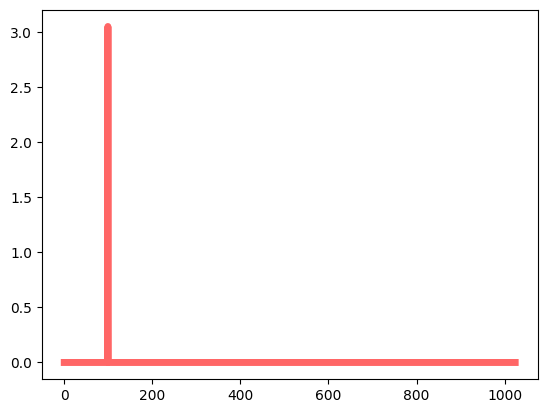

In [11]:
fit_a, fit_b, fit_loc, fit_scale = truncnorm.fit(dataset_pd['output_len'])

print(fit_a, fit_b, fit_loc, fit_scale)
x = np.linspace(0, 1024, 1024)
plt.plot(x, truncnorm.pdf(x, fit_a, fit_b, fit_loc, fit_scale),
         'r-', lw=5, alpha=0.6, label='truncnorm pdf')